In [17]:
!pip install opencv-python

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
import cv2
import matplotlib.pyplot as plt

In [12]:
#cv2.dnn- Deep Neural Network (DNN) module
#Used to run pre-trained models from various frameworks like TensorFlow
#"graph_opt.pb" is the optimized computational graph of a TensorFlow model.
# compiled version of the neural network that includes weights and architecture,
# optimized for inference.
#MobileNet as the backbone
# to extract features from the input image, because MobileNet is lightweight and
# fast — ideal for real-time applications.
net = cv2.dnn.readNetFromTensorflow("graph_opt.pb")


In [13]:
#The model expects images resized to 368×368 pixels.
inWidth = 368
inHeight=368


In [14]:
#Body Parts Definition - 18 key body points defined (nose, neck, shoulders, elbows, etc.)
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

#Keypoints connected to draw the skeleton:
POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

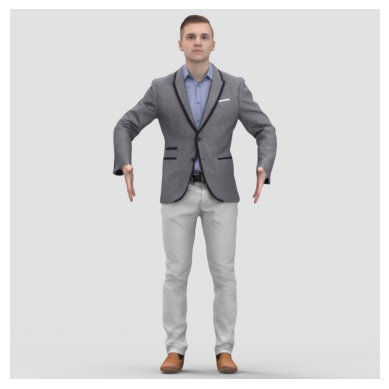

In [15]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(r'C:\Users\HP\Desktop\Academics\sem-6\INT345 COMPUTER VISION\CA1\VscodeCV\image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Image Pose Detection

In [16]:
def pose_estimation (frame,thr=0.1):
  #Extracts width and height of the input frame.
  frameWidth=frame.shape[1]
  frameHeight=frame.shape[0]
  #Converts the image into a blob (standard input format for deep networks).
  net.setInput(cv2.dnn.blobFromImage (frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
  out=net.forward()
  out=out[:, :19,:, :] 

  assert(len(BODY_PARTS) == out.shape[1])

  points = []
  for i in range(len(BODY_PARTS)):
     # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

       #Finds the location with highest confidence using cv2.minMaxLoc().
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        
        points.append((int(x), int(y)) if conf > thr else None)


  for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]


        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)# # Draw line between parts
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)#draws red circles
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

  t, _ = net.getPerfProfile()
  freq = cv2.getTickFrequency() / 1000
  # Adds inference time in milliseconds onto the frame as text.
  cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
  return frame


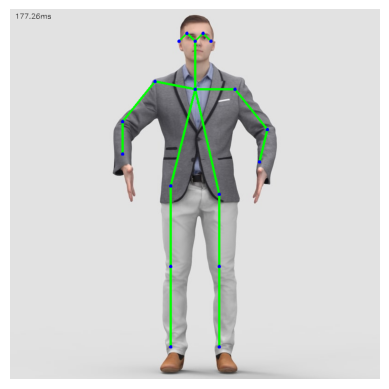

In [17]:
estimated_image=pose_estimation(image)
plt.imshow(image)
plt.axis('off')    # Hide axes
plt.show()

Video Pose Detection

In [10]:

cap = cv2.VideoCapture(r'C:\Users\HP\Desktop\Academics\sem-6\INT345 COMPUTER VISION\CA1\VscodeCV\V1.mp4')
cap.set(3,800)
cap.set(4,800)

if not cap.isOpened():
  cap=cv2.VideoCapture(0)

if not cap.isOpened():
  raise IOError("Cannot open video")


while True:
  hasFrame,frame=cap.read()
  if not hasFrame:
    cv2.waitKey()
    break

  frameWidth=frame.shape[1]
  frameHeight=frame.shape[0]
  net.setInput(cv2.dnn.blobFromImage (frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
  out=net.forward()
  out=out[:, :19,:, :] 

  assert(len(BODY_PARTS) == out.shape[1])
  thr=0.1
  points = []
  for i in range(len(BODY_PARTS)):
     # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

      
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)


  for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]


        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

  t, _ = net.getPerfProfile()
  freq = cv2.getTickFrequency() / 1000
  cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

  cv2.imshow("Frame", frame)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break



In [11]:
cap.release()
cv2.destroyAllWindows()

Real time pose detection By Mediapipe

In [18]:
import cv2
import mediapipe as mp #Contains pretrained models for pose, face, hand, etc.

#Initialize MediaPipe Pose Components
mp_drawing = mp.solutions.drawing_utils# Utility to draw landmarks and connections and
mp_pose = mp.solutions.pose#Contains the actual pose detection solution.

# Start web cam
cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5,#Threshold to consider detection as valid (50% here).
                  min_tracking_confidence=0.5) as pose:# Confidence for tracking landmarks between frames.

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make pose detection
        results = pose.process(image)

        # Draw pose landmarks
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Display the output
        cv2.imshow('Pose Detection', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv2.destroyAllWindows()

In [9]:
cap.release()
cv2.destroyAllWindows()